In [19]:
import ugradio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import pandas as pd
import new_interf

from datetime import datetime, timedelta



In [20]:
m17_data = pd.read_csv('long_obs_data2.csv')

m17_volts = m17_data['Voltages']
m17_times = m17_data['Times']
#print(datetime.utcfromtimestamp(moon_times[0]).strftime('%Y-%m-%d %H:%M:%S'), "in UTC")
def utc_to_local(unix_time):
    utc_dt = datetime.utcfromtimestamp(unix_time)
    time = utc_dt - timedelta(hours=8)
    return time.strftime('%Y-%m-%d %H:%M:%S')
t= utc_to_local(m17_times[0])
print(t, "local time")

print(m17_times[0], "time of observation in bullshit unix")
m17_times -= m17_times[0]  # this is shorthand for moontime = itself minus moontime[0]
dt = m17_times[1] - m17_times[0]  # this is the time step between samples
print(len('long_obs_data2.csv'))

2022-03-16 08:29:43 local time
1647448183.909691 time of observation in bullshit unix
18


<IPython.core.display.Javascript object>


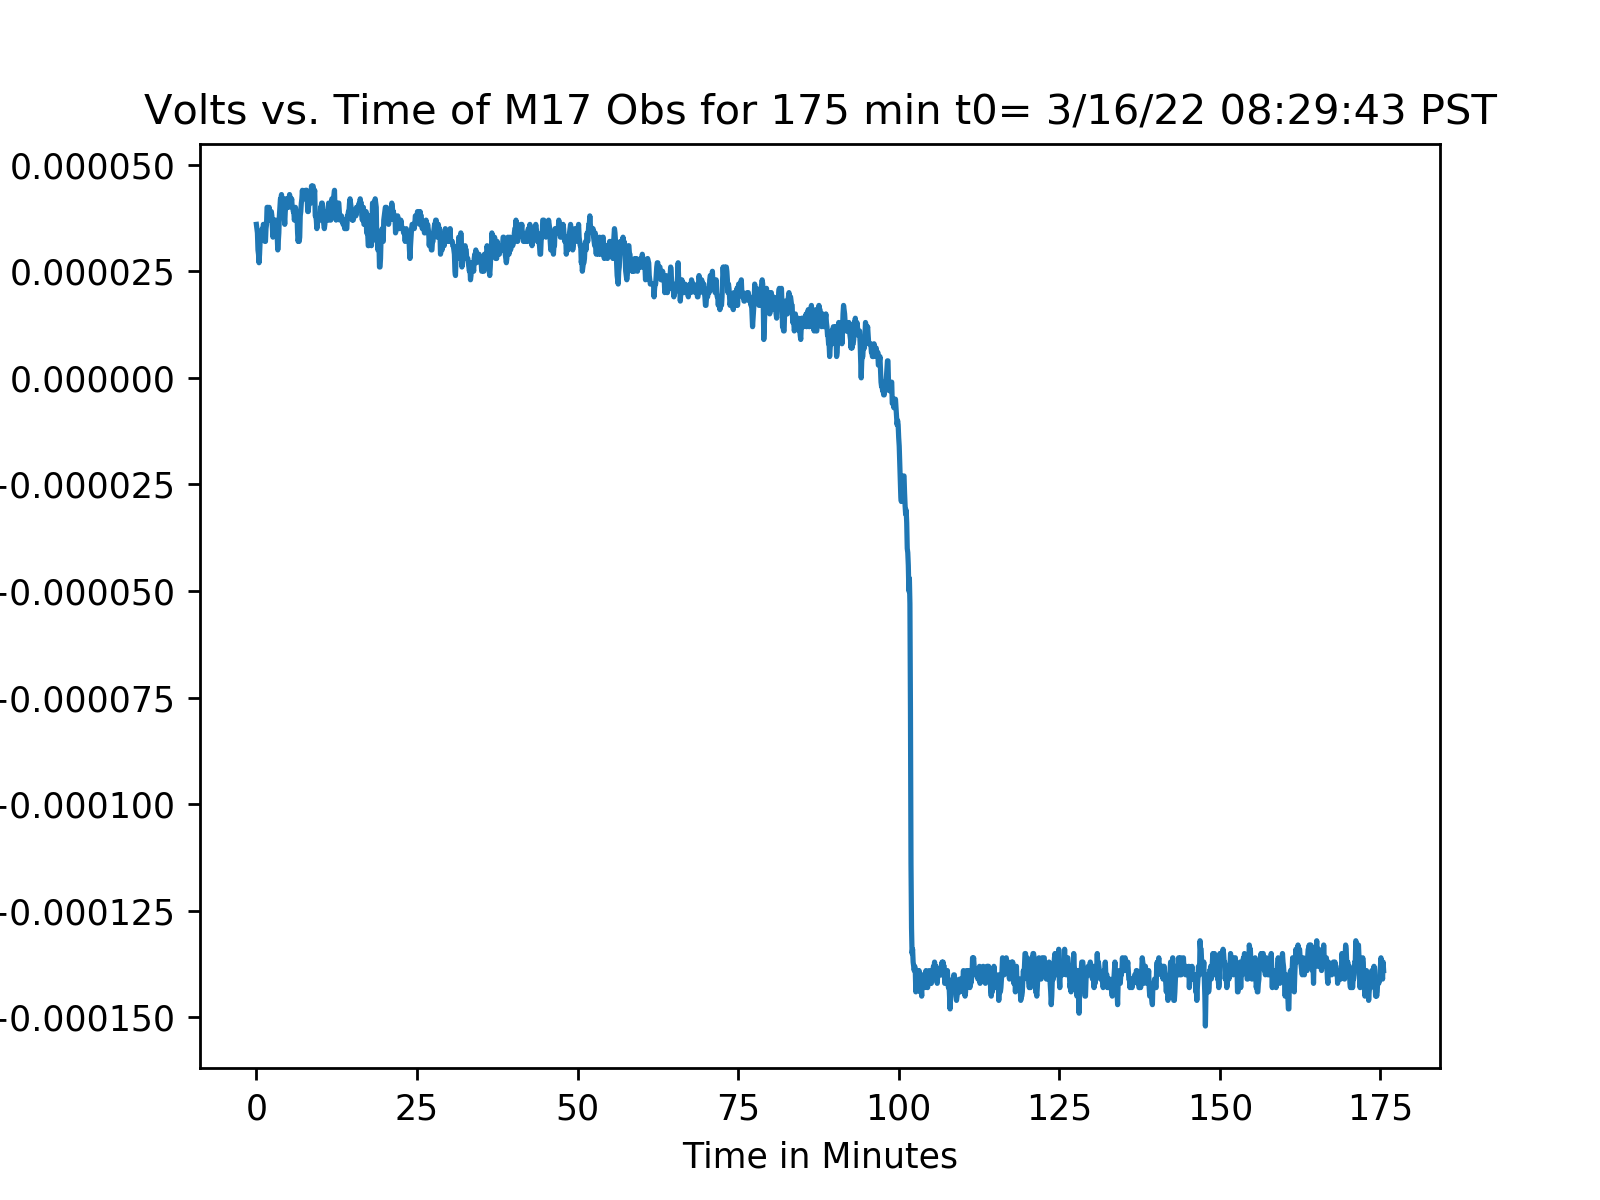

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


In [21]:
plt.figure()
plt.xlabel("Time in Minutes")
plt.ylabel("Voltage in Volts")
plt.title("Volts vs. Time of M17 Obs for 175 min t0= 3/16/22 08:29:43 PST")
plt.plot(m17_times/60, m17_volts)
# we can see the frequencies are getting smaller 
# this happens at the horizons 
# frequency changes as the cosine of the angle (highest at zentih and lowest at horizon)

<IPython.core.display.Javascript object>


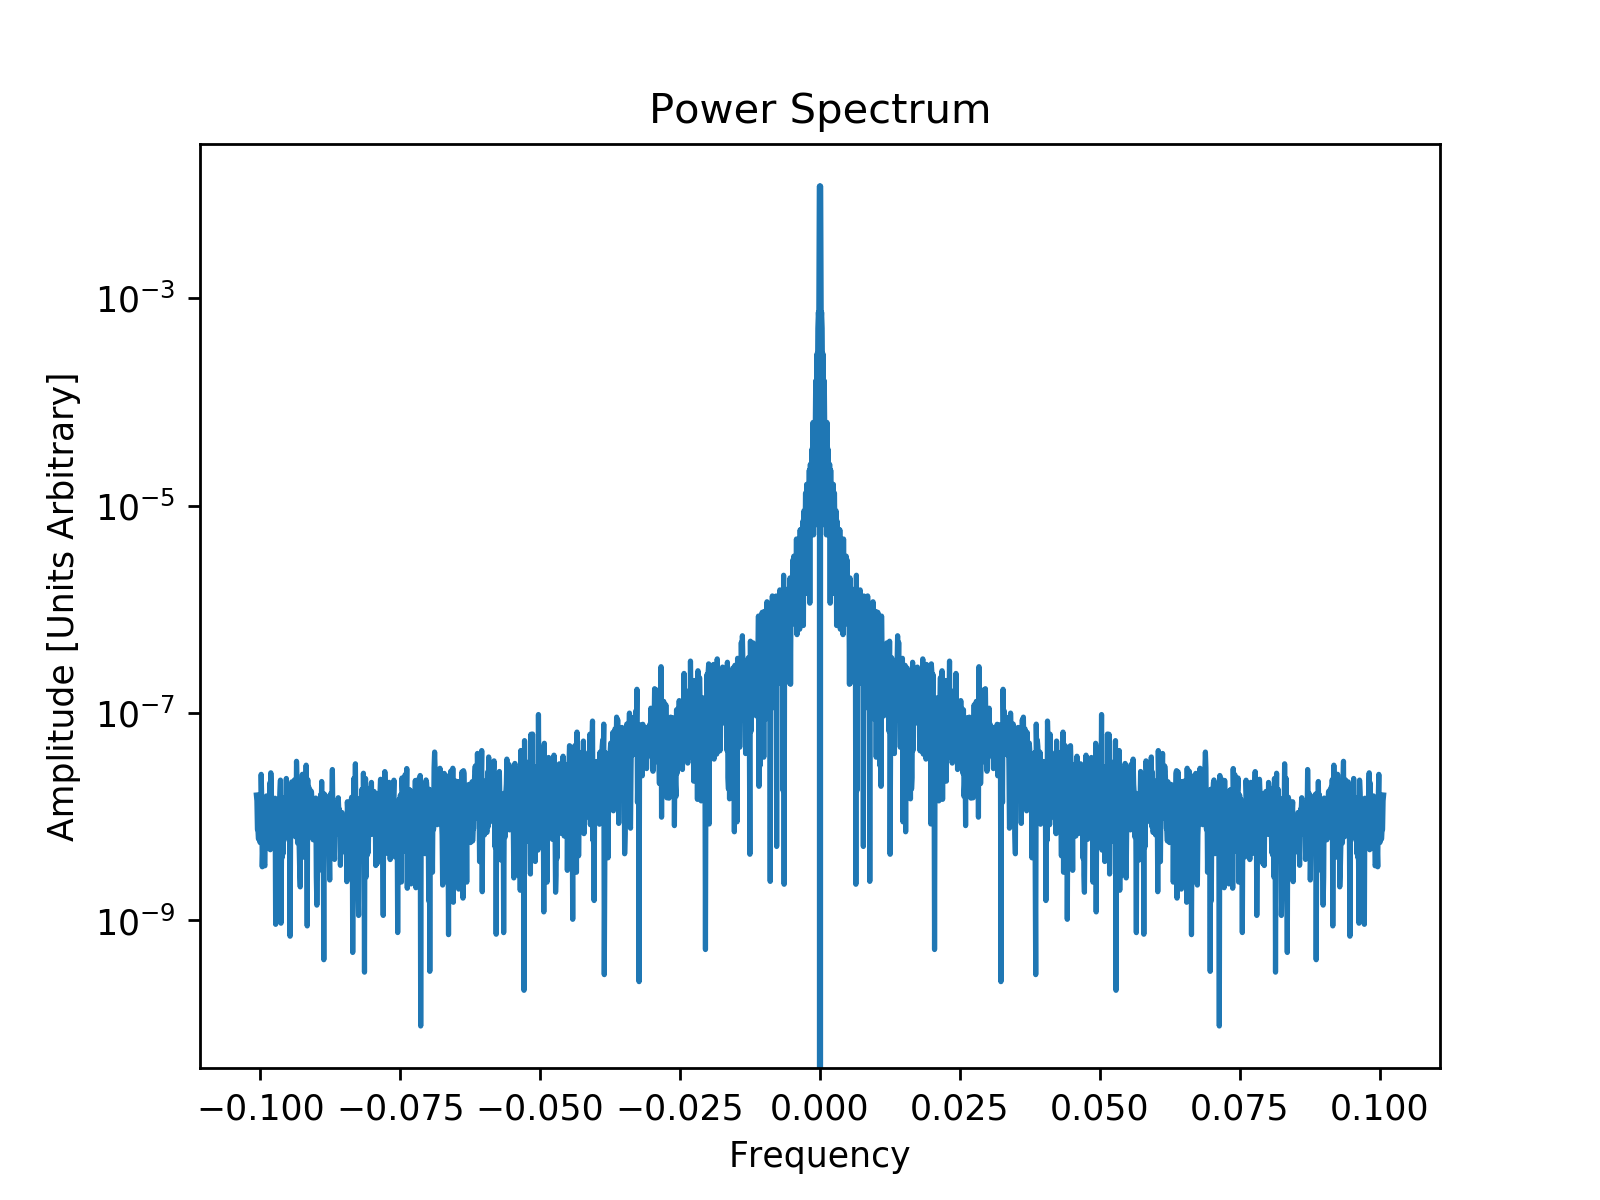

In [22]:
voltage_spectrum = np.fft.fft(m17_volts)
voltage_spectrum[0] = 0 # this is the same as subtracting the mean in the timeseries data 
power_spectrum = np.abs(voltage_spectrum)**2
frequencies = np.fft.fftfreq(len(power_spectrum), dt)

plt.figure()
plt.title("Power Spectrum")
plt.xlabel("Frequency")
plt.ylabel("Amplitude [Units Arbitrary]")
plt.semilogy(np.fft.fftshift(frequencies), np.fft.fftshift(power_spectrum)) # shifting the arrays to read correctly

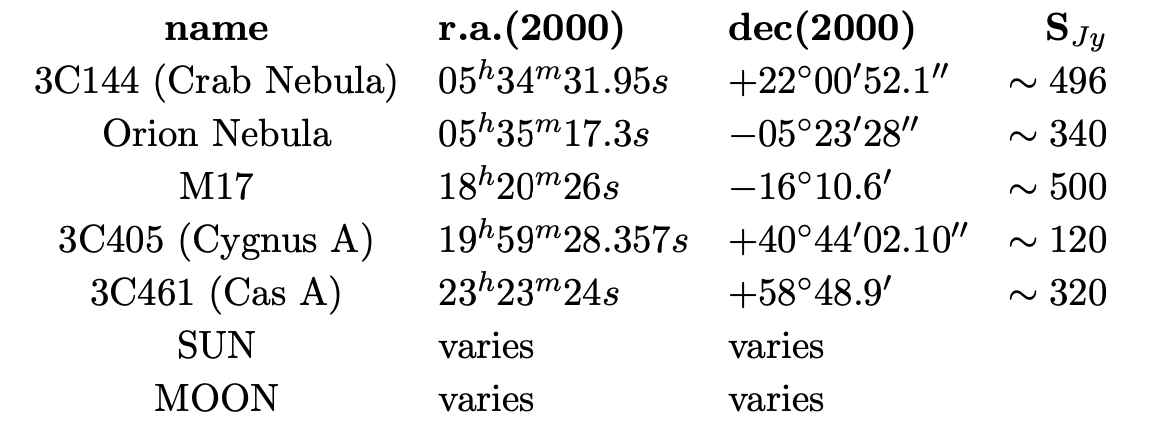


In [5]:
RA_deg= new_interf.time2deg(18, 20, 2)
print(RA_deg, "RA in degrees")
arc_dec= 10.6/60 #converting arc min to degrees 
arc_dec
dec = -16 - arc_dec
print(dec, "Dec in degrees")

precess_ra, precess_dec = ugradio.coord.precess(RA_deg, dec)
print("precess_ra is", precess_ra, "precess_dec is", precess_dec )
RA = np.radians(precess_ra)
Dec = np.radians(precess_dec)
print("RA is", RA, "Dec", Dec )

275.0083333333333 RA in degrees
-16.176666666666666 Dec in degrees
precess_ra is 275.007356180372 precess_dec is -16.17741001778704
RA is 4.799783832552269 Dec -0.2823490692554983


In [23]:
m17_times_JD= ugradio.timing.julian_date(m17_times)
m17_times_LST= ugradio.timing.lst(m17_times_JD)
print(m17_times_LST)
delta = Dec # declination 
B_ew = 20 # baseline east-west in meters
h_s = m17_times_LST - RA # hour angle = LST - RA
h_s = np.where(h_s<0, h_s +2*np.pi, h_s) # adding 2pi to when it is negative angles

wl = .0250  # wavelength in meters

[5.89881367 5.89917549 5.8995401  ... 0.38275616 0.38312076 0.38348537]


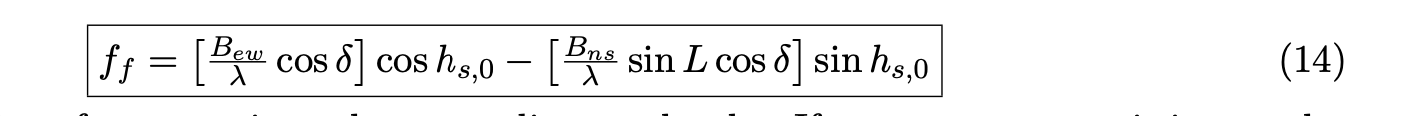


<IPython.core.display.Javascript object>


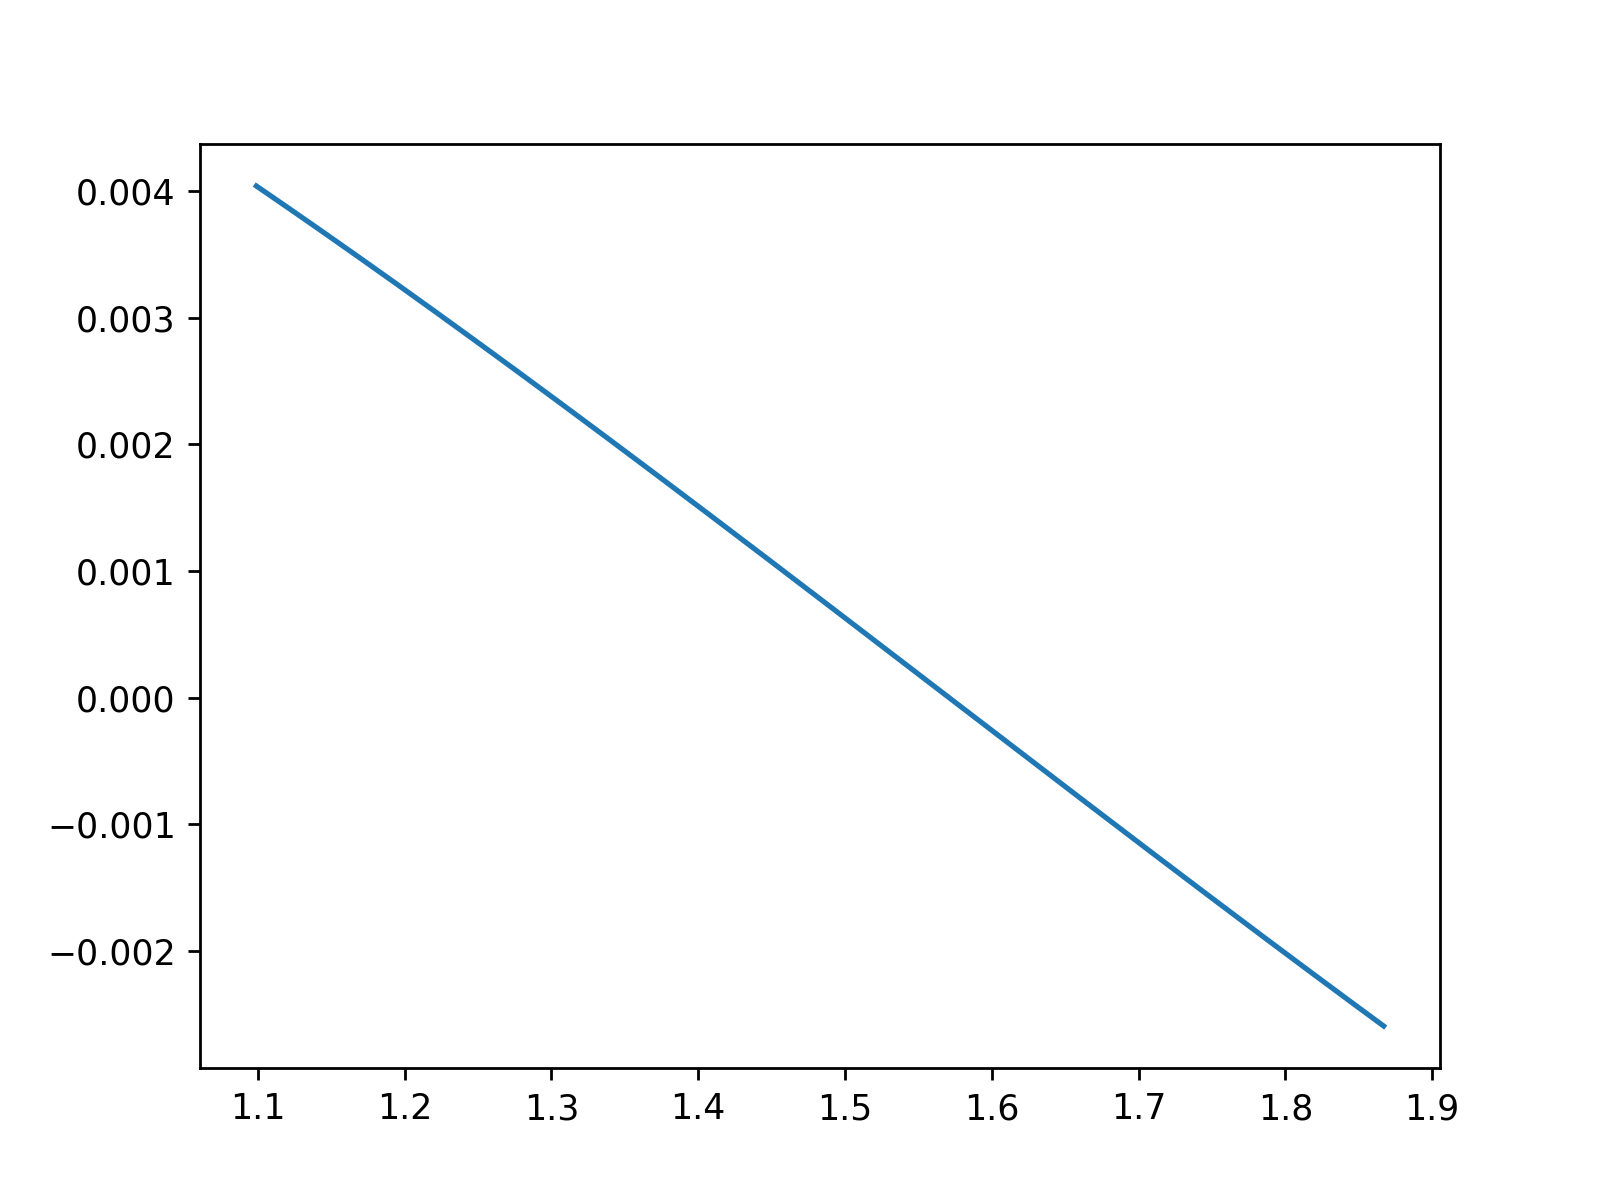

<IPython.core.display.Javascript object>


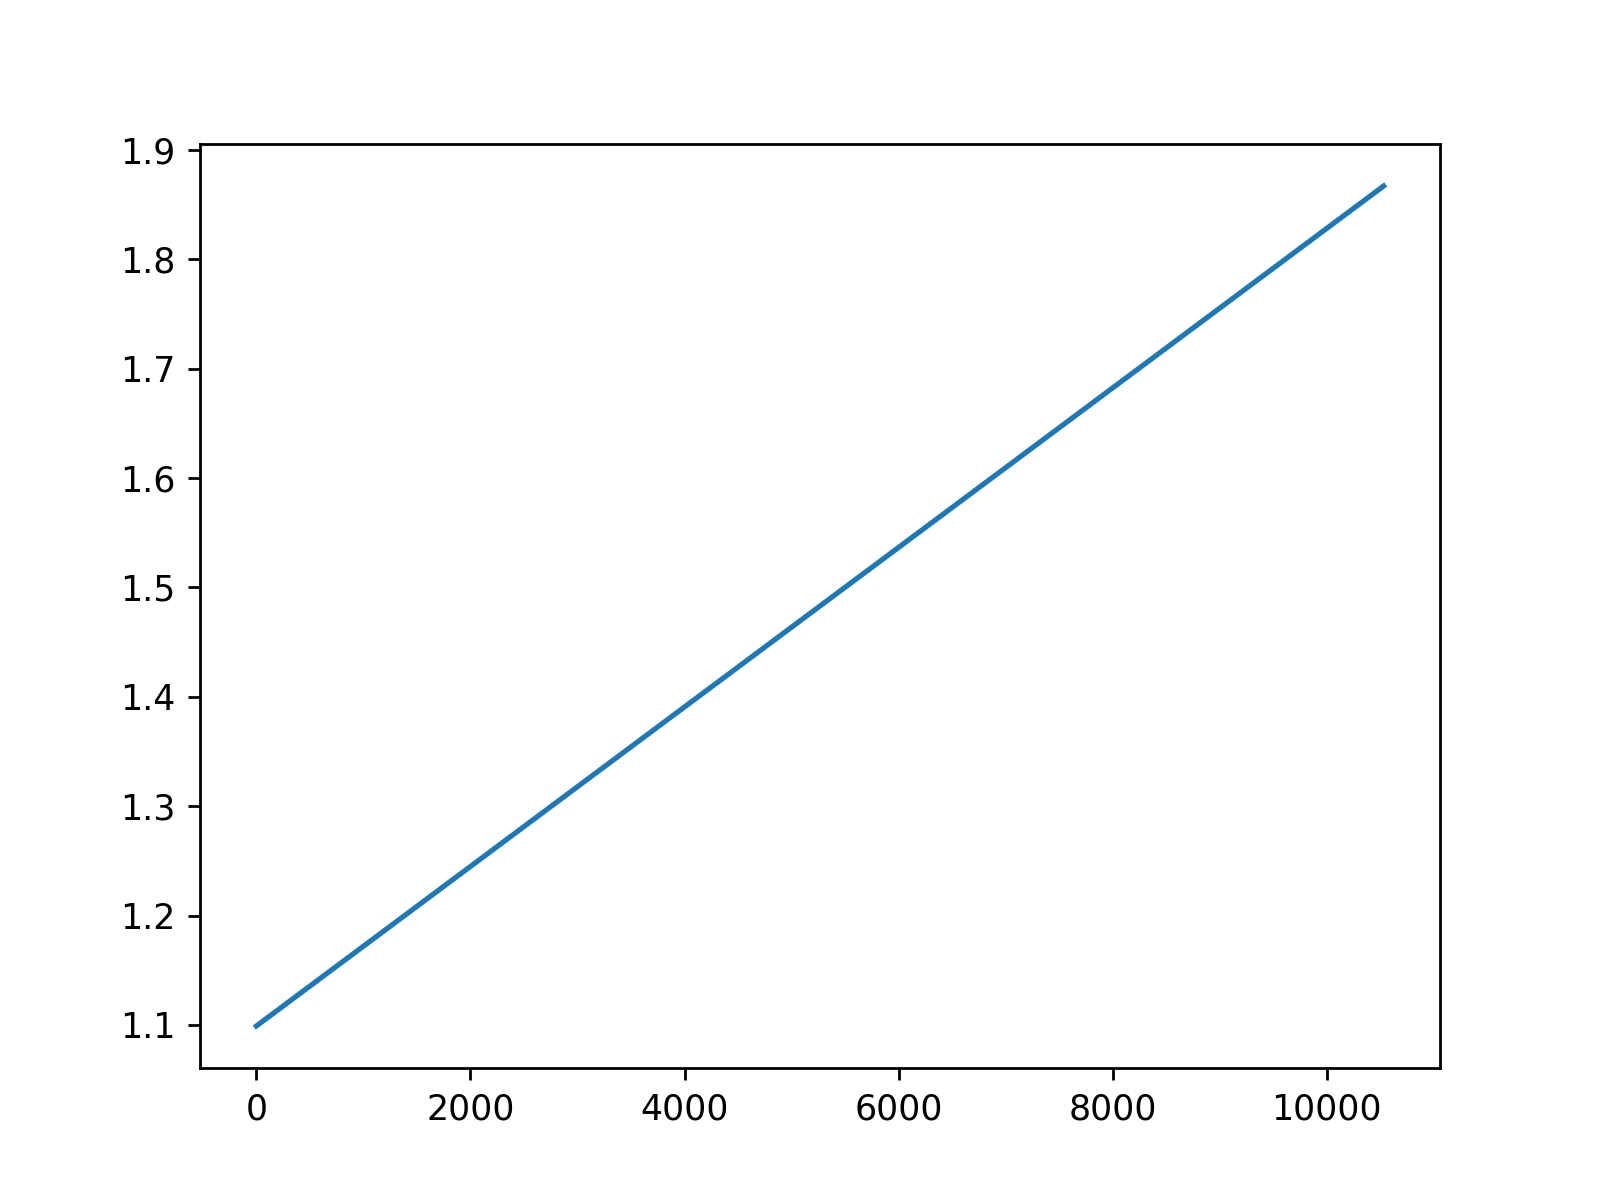

In [24]:
plt.figure()
f = (B_ew/wl * np.cos(delta)) * np.cos(h_s) # we are assuming baseline north-south is 0 
#which is not really true but whatever
f/=24*3600

plt.plot( h_s, f)
plt.figure()
plt.plot(m17_times, h_s)

# we think this is part of a cosine 
# these are the local fringe freqs

<IPython.core.display.Javascript object>


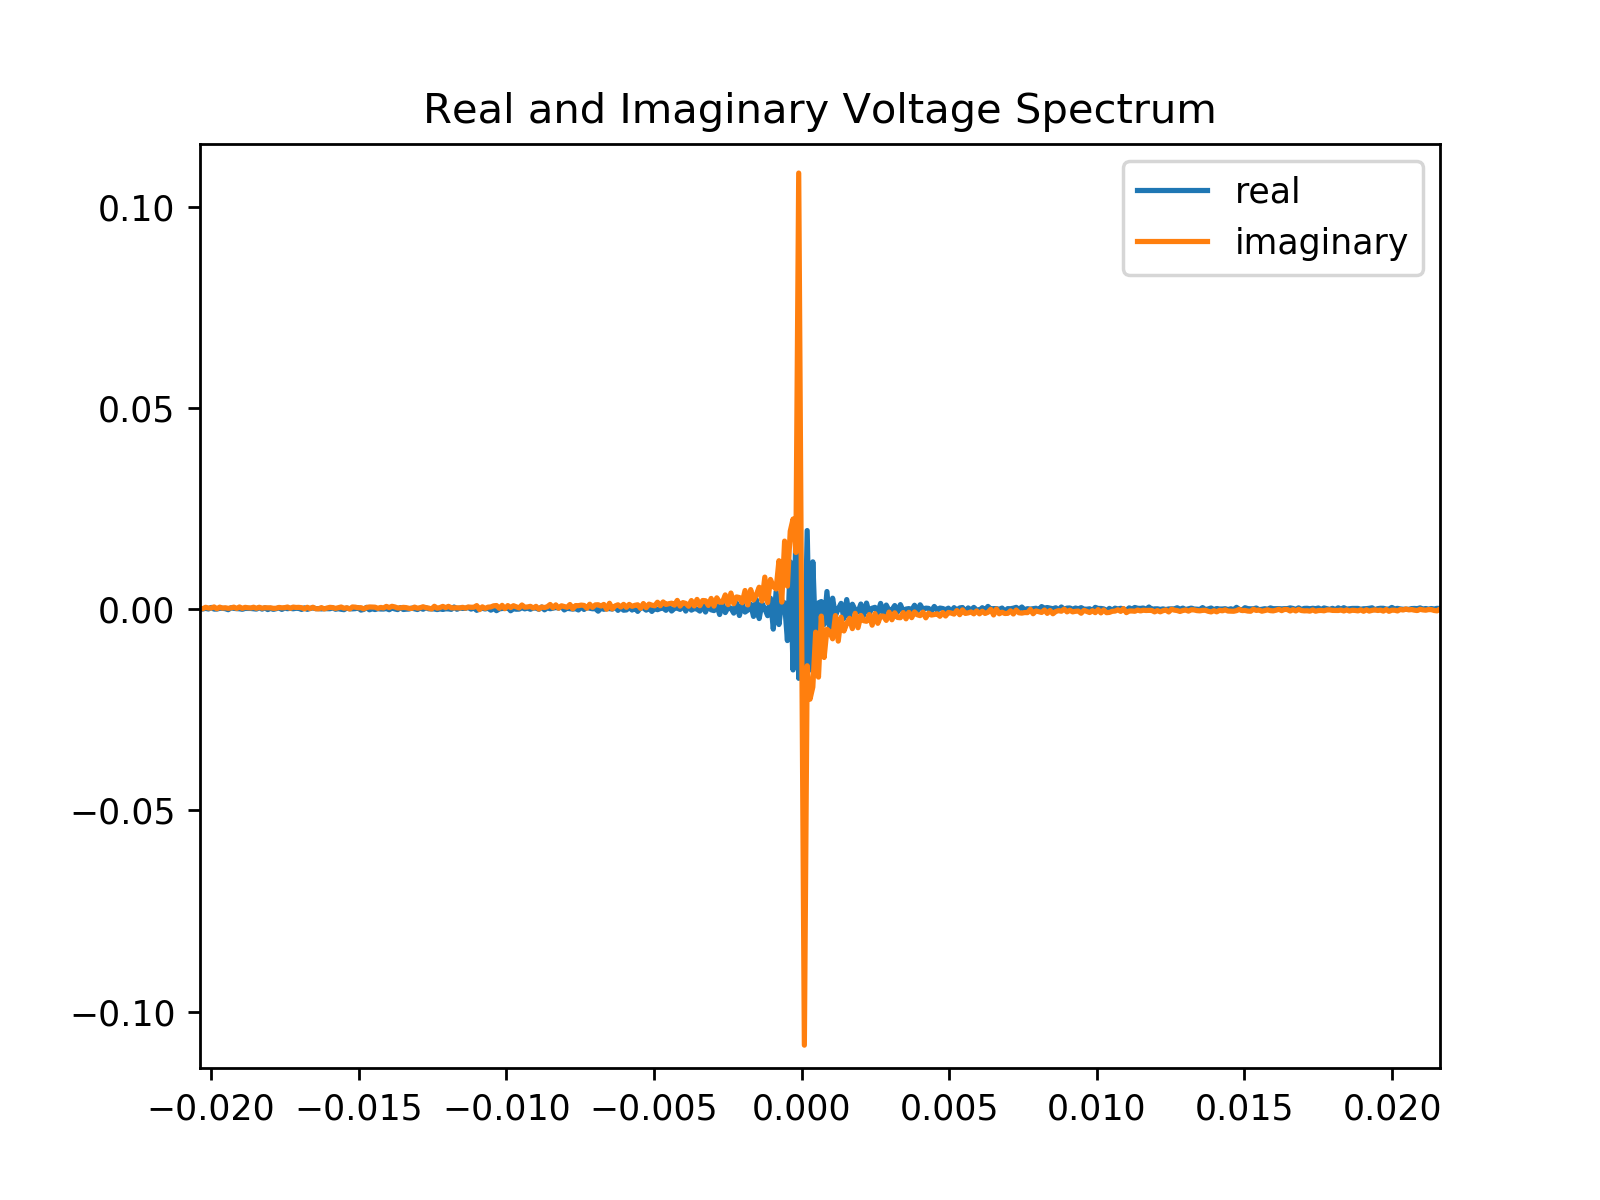

In [5]:
plt.figure()
plt.title("Real and Imaginary Voltage Spectrum")

plt.plot(np.fft.fftshift(frequencies), np.fft.fftshift(voltage_spectrum.real), label="real")
plt.plot(np.fft.fftshift(frequencies), np.fft.fftshift(voltage_spectrum.imag), label = "imaginary")# shifting the arrays to read correctly
plt.legend()

In [6]:
m17_spectra = new_interf.f_transform(m17_volts)
new_interf.f_transform??

<IPython.core.display.Javascript object>


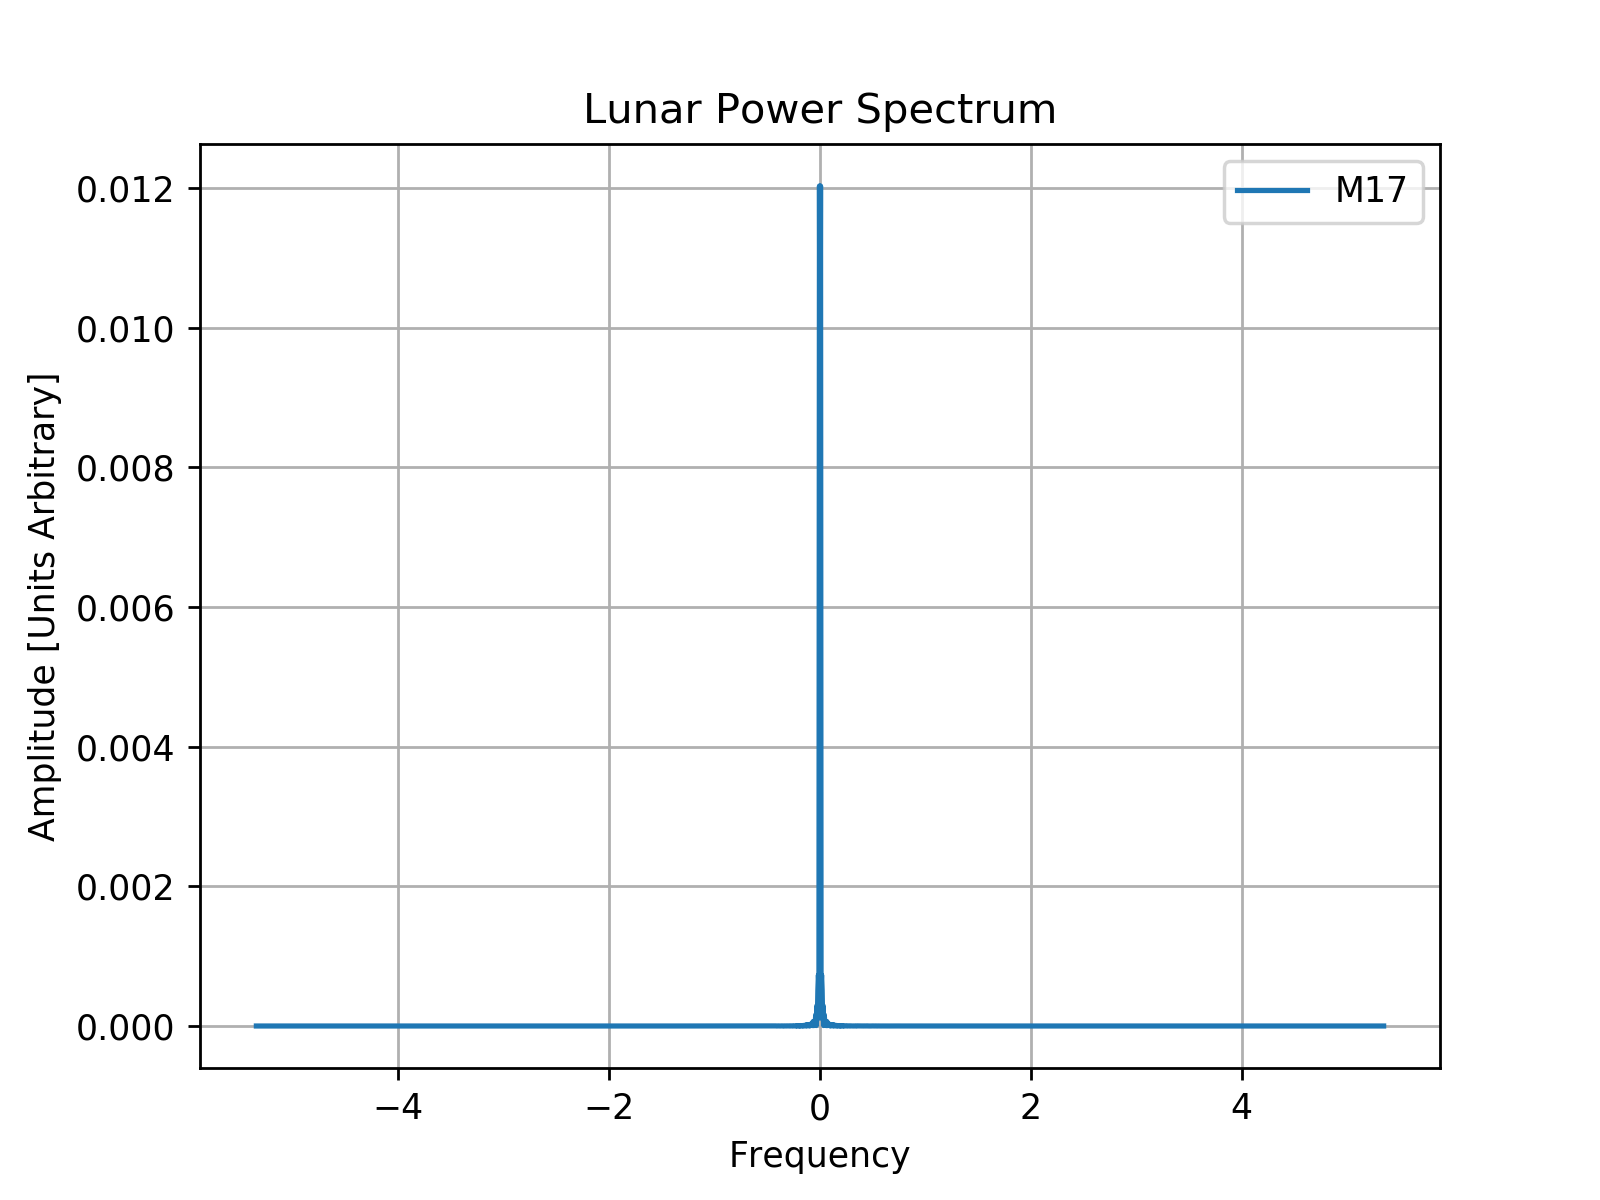

In [7]:
plt.figure()
plt.grid()
plt.title('Lunar Power Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Amplitude [Units Arbitrary]')
plt.plot(m17_spectra[0], m17_spectra[1], label = "M17")
plt.legend()
plt.show()
